# In case, the file import data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks
# !ls

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# Install libraries
!pip install mne
!pip install pyriemann
!pip install MOABB
!pip install  scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# References
- EEGANet: Removal of Ocular Artifact from the EEG Signal Using Generative Adversarial Networks
    - https://ieeexplore.ieee.org/document/9627782
    - https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/SRGAN
    - https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/srgan
- Datasets
    - http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014004.html#moabb.datasets.BNCI2014004
- Notes
    - 

## Import libraries and read files

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
from mne.preprocessing import ICA
from sklearn.preprocessing import MinMaxScaler
import pywt
import scipy
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,
                               corrmap)
from sklearn.neighbors import KDTree

import seaborn as sns

import os
import re

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import warnings
mne.set_log_level("CRITICAL")
warnings.filterwarnings("ignore")

## Load data

In [ ]:
n_event_ids = 20
selected_data_len = 2000

# 60 events/ 1 run/ 3 sessions/ 1 subject
batch_size = 10
n_subjs = 20
events_per_run = 20
runs_per_session = 1
sessions_for_train = 2
sessions_for_eval = 1
events_per_subj_for_train = int(events_per_run * runs_per_session * sessions_for_train)
events_per_subj_for_eval = int(events_per_run * runs_per_session * sessions_for_eval)
train_split = int(events_per_subj_for_train * 0.8)

list_epoch_types = ["All epochs", "Bad", "Good"]

In [ ]:
EOG_ref = "EEGANet"
ECG_ref = None

# LOAD EEG DATA
train_good_epochs = np.load(f'Datasets/Shin2017A/gb_npy_files/train_good_epochs_{EOG_ref}-{ECG_ref}.npy')
train_bad_epochs = np.load(f'Datasets/Shin2017A/gb_npy_files/train_bad_epochs_{EOG_ref}-{ECG_ref}.npy')
eval_good_epochs = np.load(f'Datasets/Shin2017A/gb_npy_files/eval_good_epochs_{EOG_ref}-{ECG_ref}.npy')
eval_bad_epochs = np.load(f'Datasets/Shin2017A/gb_npy_files/eval_bad_epochs_{EOG_ref}-{ECG_ref}.npy')

# LOAD EVENT
train_good_events = np.load(f'Datasets/Shin2017A/gb_npy_files/train_good_events_{EOG_ref}-{ECG_ref}.npy')
train_bad_events = np.load(f'Datasets/Shin2017A/gb_npy_files/train_bad_events_{EOG_ref}-{ECG_ref}.npy')
eval_good_events = np.load(f'Datasets/Shin2017A/gb_npy_files/eval_good_events_{EOG_ref}-{ECG_ref}.npy')
eval_bad_events = np.load(f'Datasets/Shin2017A/gb_npy_files/eval_bad_events_{EOG_ref}-{ECG_ref}.npy')

In [ ]:
print(train_good_epochs.shape, train_bad_epochs.shape,
      eval_good_epochs.shape, eval_bad_epochs.shape,
      train_good_events.shape, train_bad_events.shape,
      eval_good_events.shape, eval_bad_events.shape)

(651, 30, 2000) (149, 30, 2000) (324, 30, 2000) (76, 30, 2000) (651, 3) (149, 3) (324, 3) (76, 3)


In [ ]:
print(np.concatenate((train_good_epochs, train_bad_epochs), axis=0).shape)
print(np.concatenate((train_good_events, train_bad_events), axis=0).shape)

(800, 30, 2000)
(800, 3)


# Classification
- 01 = CSP + SVM
- 02 = CSP + LDA
- 03 = EEGNet
    - Note of EEGNET's problems
        - FC Layer
            x = x.reshape(-1, 4*2*7)
        - Label must start with 0
    - Data format:
        Datatype - float32 (both X and Y) <br>
        X.shape - (#samples, 1, #timepoints,  #channels) <br>
        Y.shape - (#samples)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
def data_for_EEGNET(input_epochs):
    # X.shape - (#epochs, 1, #timepoints, #channels)
    output_epochs = []
    for e_epoch in input_epochs:
        e_epoch = e_epoch.transpose()
        e_epoch = np.expand_dims(e_epoch,axis=0)
        # print(e_epoch.shape)
        output_epochs.append(e_epoch)
        # break
    return np.array(output_epochs).astype('float32')

In [ ]:
class EEGNet(nn.Module):
    def __init__(self):
        # Modify self.T, self.fc1 
        super(EEGNet, self).__init__()
        self.T = 2000 # #samples per task
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1, 30), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 32))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 4, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(4, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        self.fc1 = nn.Linear(4*2*125, 1)
        

    def forward(self, x):
        # Layer 1
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.25)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.25)
        x = self.pooling2(x)
        
        # Layer 3
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        
        # FC Layer
        x = x.reshape(-1, 4*2*125)
        x = torch.sigmoid(self.fc1(x))
        return x


net = EEGNet().cuda(0)
print(net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 2000, 30)).cuda(0))))
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters())

tensor([[0.2315]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
def evaluate(model, X, Y, params = ["acc"]):
    results = []
    batch_size = 100
    
    predicted = []
    
    for i in range(int(len(X)/batch_size)):
        s = i*batch_size
        e = i*batch_size+batch_size
        
        inputs = Variable(torch.from_numpy(X[s:e]).cuda(0))
        pred = model(inputs)
        
        predicted.append(pred.data.cpu().numpy())
        
        
    inputs = Variable(torch.from_numpy(X).cuda(0))
    predicted = model(inputs)
    
    predicted = predicted.data.cpu().numpy()
    
    for param in params:
        if param == 'acc':
            results.append(accuracy_score(Y, np.round(predicted)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted))
        if param == "recall":
            results.append(recall_score(Y, np.round(predicted)))
        if param == "precision":
            results.append(precision_score(Y, np.round(predicted)))
        if param == "fmeasure":
            precision = precision_score(Y, np.round(predicted))
            recall = recall_score(Y, np.round(predicted))
            results.append(2*precision*recall/ (precision+recall))
    return results

## Run

In [ ]:
for idx_e_subj in range(3):
    train_split = int(events_per_subj_for_train * 0.8)
    # Assign data and label for Training, Validation, Evaluation

    start_idx_train = int(idx_e_subj * events_per_subj_for_train)
    end_idx_train = start_idx_train + int(events_per_subj_for_train * 0.8)
    start_idx_val = end_idx_train
    end_idx_val = int((idx_e_subj+1) * events_per_subj_for_train)
    start_idx_eval = int((idx_e_subj)*events_per_subj_for_eval)
    end_idx_eval  = int((idx_e_subj+1)*events_per_subj_for_eval)

    print(f"start_idx_train: {start_idx_train}")
    print(f"end_idx_train: {end_idx_train}")
    print(f"start_idx_val: {start_idx_val}")
    print(f"end_idx_val: {end_idx_val}")
    print(f"start_idx_eval: {start_idx_eval}")
    print(f"end_idx_eval: {end_idx_eval}")
    print('='*100)

    # break

start_idx_train: 0
end_idx_train: 32
start_idx_val: 32
end_idx_val: 40
start_idx_eval: 0
end_idx_eval: 20
start_idx_train: 40
end_idx_train: 72
start_idx_val: 72
end_idx_val: 80
start_idx_eval: 20
end_idx_eval: 40
start_idx_train: 80
end_idx_train: 112
start_idx_val: 112
end_idx_val: 120
start_idx_eval: 40
end_idx_eval: 60


In [ ]:
print(train_good_epochs.shape, train_bad_epochs.shape,
      eval_good_epochs.shape, eval_bad_epochs.shape,
      train_good_events.shape, train_bad_events.shape,
      eval_good_events.shape, eval_bad_events.shape)

(651, 30, 2000) (149, 30, 2000) (324, 30, 2000) (76, 30, 2000) (651, 3) (149, 3) (324, 3) (76, 3)


In [ ]:
list_epoch_types

['All epochs', 'Bad', 'Good']

In [ ]:
best_test_types = []

for idx_e_type, e_type in enumerate(list_epoch_types):
    print(e_type)

    if e_type == 'All epochs':

        X = np.concatenate((train_good_epochs, train_bad_epochs), axis=0)
        y = np.concatenate((train_good_events, train_bad_events), axis=0)[:, -1]

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                          shuffle=True, 
                                                          stratify=y,
                                                          random_state=42)
        
        X_test = np.concatenate((eval_good_epochs, eval_bad_epochs), axis=0)
        y_test = np.concatenate((eval_good_events, eval_bad_events), axis=0)[:, -1]

    elif e_type == 'Bad':

        X = train_bad_epochs
        y = train_bad_events[:, -1]

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                          shuffle=True, 
                                                          stratify=y,
                                                          random_state=42)
        
        X_test = eval_bad_epochs
        y_test = eval_bad_events[:, -1]

    elif e_type == 'Good':

        X = train_good_epochs
        y = train_good_events[:, -1]

        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                          shuffle=True, 
                                                          stratify=y,
                                                          random_state=42)
        
        X_test = eval_good_epochs
        y_test = eval_good_events[:, -1]

    print(X.shape, y.shape)
    print(X[0,0,:5])
    print(y[:5])

    # Modify the input data and its label
    X_train = data_for_EEGNET(X_train)
    X_val = data_for_EEGNET(X_val)
    X_test = data_for_EEGNET(X_test)

    y_train = y_train - 1 # Start with 0
    y_val = y_val - 1 # Start with 0
    y_test = y_test - 1 # Start with 0

    print(f"start_idx_train: {start_idx_train}")
    print(f"end_idx_train: {end_idx_train}")
    print(f"start_idx_val: {start_idx_val}")
    print(f"end_idx_val: {end_idx_val}")
    print(f"start_idx_eval: {start_idx_eval}")
    print(f"end_idx_eval: {end_idx_eval}")

    print(y_train[:10])
    print(y_val[:10])
    print(y_test[:10])

    print('-'*100)
    
    # Assign a model and its hyperparameters
    # del net
    net = EEGNet().cuda(0)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters())

    list_training_loss = []
    list_train_performance = []
    list_valid_performance = []
    list_test_performance = []

    for epoch in range(100):  # loop over the dataset multiple times
        print("\nEpoch ", epoch)
        net.train()
        running_loss = 0.0
        for i in range(int((len(X_train)/batch_size-1))):
            s = i*batch_size
            e = i*batch_size+batch_size
            
            inputs = torch.from_numpy(X_train[s:e])
            labels = torch.FloatTensor(np.array([y_train[s:e]]).T*1.0)
            
            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda(0)), Variable(labels.cuda(0))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            
            optimizer.step()
            
            running_loss += loss.item()
            
        # Validation accuracy
        net.eval()
        params = ["acc", "auc", "fmeasure"]
        print(params)

        e_train_performance = evaluate(net, X_train, y_train, params)
        e_valid_performance = evaluate(net, X_val, y_val, params)
        e_test_performance = evaluate(net, X_test, y_test, params)

        print("Training Loss ", running_loss)
        print("Train - ", e_train_performance)
        print("Validation - ", e_valid_performance)
        print("Test - ", e_test_performance)

        list_training_loss.append(running_loss)
        list_train_performance.append(e_train_performance)
        list_valid_performance.append(e_valid_performance)
        list_test_performance.append(e_test_performance)

    list_training_loss = np.array(list_training_loss)
    list_train_performance = np.array(list_train_performance)
    list_valid_performance = np.array(list_valid_performance)
    list_test_performance = np.array(list_test_performance)

    best_acc = np.argmax(list_test_performance[:,0])
    print(f"Epoch with best accuracy is {best_acc}")
    best_test_performance = list_test_performance[best_acc,:]
    best_test_types.append(best_test_performance)
    print(f"'='*50 + 'END OF {e_type} epoch type + '='*50")


All epochs
(800, 30, 2000) (800,)
[-0.08427826 -0.08716451 -0.0831288  -0.07596581 -0.07719874]
[1 2 1 2 1]
start_idx_train: 80
end_idx_train: 112
start_idx_val: 112
end_idx_val: 120
start_idx_eval: 40
end_idx_eval: 60
[0 1 1 0 0 1 1 1 1 1]
[1 0 0 1 1 0 1 0 0 1]
[0 1 1 0 1 0 0 1 0 1]
----------------------------------------------------------------------------------------------------

Epoch  0
['acc', 'auc', 'fmeasure']
Training Loss  54.78417718410492
Train -  [0.5296875, 0.604013671875, 0.3080459770114943]
Validation -  [0.51875, 0.48578125, 0.3063063063063063]
Test -  [0.505, 0.532775, 0.2773722627737226]

Epoch  1
['acc', 'auc', 'fmeasure']
Training Loss  44.53570529818535
Train -  [0.584375, 0.663134765625, 0.38425925925925924]
Validation -  [0.55, 0.53453125, 0.33333333333333337]
Test -  [0.4975, 0.5201250000000001, 0.28975265017667845]

Epoch  2
['acc', 'auc', 'fmeasure']
Training Loss  42.98382091522217
Train -  [0.590625, 0.7132128906249999, 0.35148514851485146]
Validation -  [

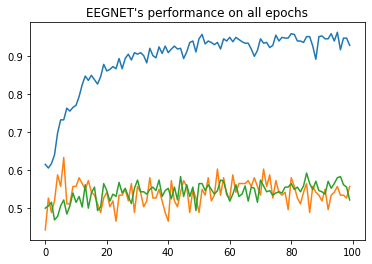

In [ ]:
plt.plot(list_train_performance[:,0])
plt.plot(list_valid_performance[:,0])
plt.plot(list_test_performance[:,0])
plt.title("EEGNET's performance on all epochs")
plt.show()

In [ ]:
best_test_types = np.array(best_test_types)
best_test_types

array([[0.63      , 0.64505   , 0.61256545],
       [0.67105263, 0.68043478, 0.6031746 ],
       [0.59259259, 0.60364782, 0.625     ]])

In [ ]:
best_test_types.shape

(3, 3)

# Save data

In [ ]:
# Change to Percentage
best_test_types = best_test_types * 100
# Create DataFrame
df_model_metrics = pd.DataFrame(data=best_test_types,
                      index= list_epoch_types,
                      columns=params)

df_model_metrics

,acc,auc,fmeasure
All epochs,63.000000,64.505000,61.256545
Bad,67.105263,68.043478,60.317460
Good,59.259259,60.364782,62.500000


In [ ]:
print(f"{EOG_ref}-{ECG_ref}")

EEGANet-None


In [ ]:
# df_model_metrics.to_csv(path_or_buf=f'result/MI/MI_GoodBad_EEGNET-{EOG_ref}-{ECG_ref}.csv', 
#                         sep=',', float_format=None)